# Learning pipeline

**Author**: Miguel Xochicale [@mxochicale](https://github.com/mxochicale)     
**Contributors**: Nhat Phung Tran Huy [@huynhatd13](https://github.com/huynhatd13); Hamideh Kerdegari [@hamidehkerdegari](https://github.com/hamidehkerdegari);  Alberto Gomez [@gomezalberto](https://github.com/)  

Feb2022; March2022 


## Summary
This notebook presents a learning pipeline to classify 4 chamber view from echocardiography datasets.

### How to run the notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server  
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 
* Kerdegari H. et al. 2021 https://github.com/vital-ultrasound/lung/tree/main/multiclass_tensorflow



# Jupyter Notebook

## 1. Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from typing import Dict, List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
#from source.models.learning_misc import train_loop, test_loop, basicVGGNet
from source.helpers.various import concatenating_YAML_via_tags, plot_dataset_classes

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]
CONFIG_FILES_PATH= 'repositories/echocardiography/scripts/config_files//users_paths_files'
YML_FILE =  'config_users_paths_files_username_' + USERNAME + '.yml'
FULL_PATH_FOR_YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, YML_FILE)

yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler
with open(FULL_PATH_FOR_YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)
    
print(f'PyTorch Version: {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')    
print(f'FULL_PATH_FOR_YML_FILE: {FULL_PATH_FOR_YML_FILE}' )

PyTorch Version: 1.9.0
Torchvision Version: 0.10.0a0
FULL_PATH_FOR_YML_FILE: /home/mx19/repositories/echocardiography/scripts/config_files//users_paths_files/config_users_paths_files_username_mx19.yml


## 2. Setting variables and loading datasets using pytorch dataloader

In [2]:
# device = torch.device(if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # "cuda:NN" can also be used
print(f'Device: {device}')

pretransform_im_size = config['pretransform_im_size']

# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=pretransform_im_size),
        transforms.ToTensor(),
    ])
else:
    pretransform = None

# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    
# These transforms have random parameters changing at each epoch.
if config['use_validation_augmentation']:
    val_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),  # in degrees
    #transforms.RandomEqualize(p=0.5),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor(), 
    ])
else:
    transform = None


train_dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list_train'],
    participant_path_json_list=config['participant_path_json_list_train'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=train_transform,
    use_tmp_storage=True,
    )

validation_dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list_validation'],
    participant_path_json_list=config['participant_path_json_list_validation'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=val_transform,
    use_tmp_storage=True,
    )


## Spliting train_dataset into train_set and test_set
Ntdt = train_dataset.__len__()
ntraining = 0.9

Ntrain=round(Ntdt*ntraining)
Ntest = round(Ntdt - (Ntdt*ntraining))
print(Ntrain, Ntest, Ntrain+Ntest)
train_set, test_set = torch.utils.data.random_split(train_dataset, [Ntrain, Ntest])


Device: cuda
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-074/T3/01NVb-003-074-3-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T1/01NVb-003-077-1-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T2/01NVb-003-077-2-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T3/01NVb-003-077-3-4CV.json (empty). Removing from list
169 19 188


## 3. Plotting Class Distribution

{'BKGR': 82, '4CV': 87}
{'BKGR': 13, '4CV': 13}
{'BKGR': 12, '4CV': 7}
Number of frames for training datasets 10140
Number of frames for testing datasets 1140


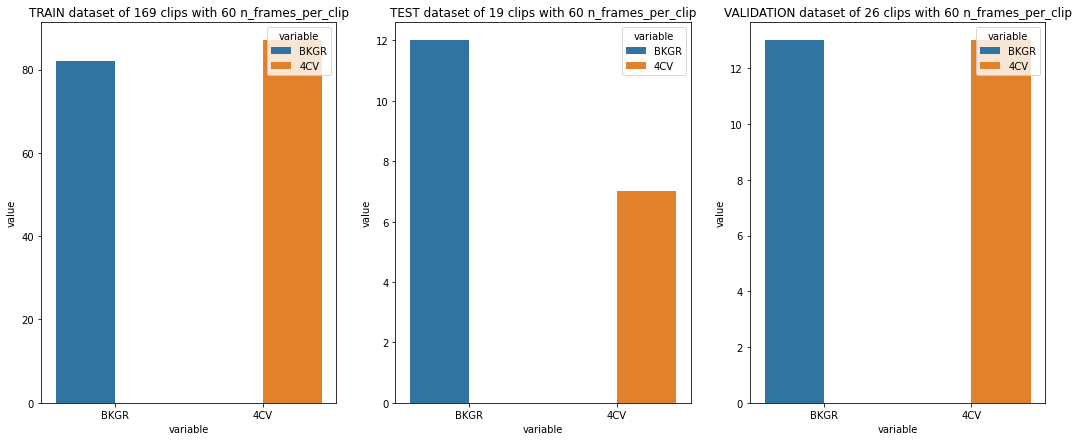

In [3]:
label_id = ('BKGR', '4CV')
number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip'] 

def get_class_distribution(dataset_obj):
    count_class_dict = {
   'BKGR': 0 ,
   "4CV": 0
    }
    
    for clip_index_i in range(len(dataset_obj)):
        data_idx = dataset_obj[clip_index_i]
        label_id_idx = data_idx[1]
        label = label_id[label_id_idx]
        count_class_dict[label]+= 1
        #count_class_dict[label]+= 1* number_of_frames_per_segment_in_a_clip

    return count_class_dict
        
        
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), 
                       x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


print(get_class_distribution(train_set))
print(get_class_distribution(validation_dataset))
print(get_class_distribution(test_set))
    
number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip']    
print(f'Number of frames for training datasets {Ntrain*number_of_frames_per_segment_in_a_clip}')
print(f'Number of frames for testing datasets {Ntest*number_of_frames_per_segment_in_a_clip}')
#print(f'Number of frames for training datasets {Ntrain*number_of_frames_per_segment_in_a_clip}')

plot_title_train_label= f'TRAIN dataset of {len(train_set)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'
plot_title_test_label= f'TEST dataset of {len(test_set)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'
plot_title_val_label= f'VALIDATION dataset of {len(validation_dataset)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))
plot_from_dict(get_class_distribution(train_set), plot_title=plot_title_train_label, ax=axes[0])
plot_from_dict(get_class_distribution(test_set), plot_title=plot_title_test_label, ax=axes[1])
plot_from_dict(get_class_distribution(validation_dataset), plot_title=plot_title_val_label, ax=axes[2])
plt.show()

###########
## NOTES ##
# HamidehK on Thu 23 Mar 14:00:00 GMT 2022
    # 65 clips with 60 frames each create 3900 frames which is a low number for traininig data.
    # Hamideh recomends to increase the training data or perhaps reduce the convs to one!

# MiguelX on Mon 28 Mar 11:35:55 BST 2022
    # Make use of 169 clips with 60 frames which results in 10140 frames for training data.


## 4. Animating frames of one clip of the dataloader

Clip Size of data_clip_idx torch.Size([1, 60, 128, 128]) of BKGR label
Clip Size of data_clip_idx[1].size() torch.Size([1, 128, 128]) of BKGR label


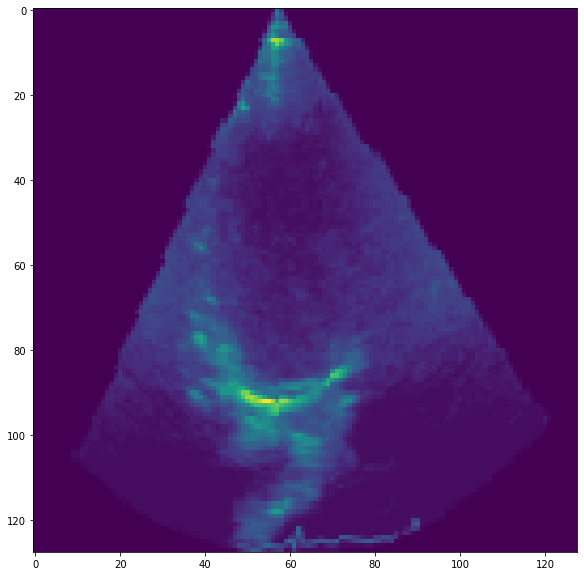

In [4]:
#average_HR =
#fps = 30
# 60 # beats per minute
#Beats-per-minute: 60 BPM
#Beats-per-second: 1 Hz
#Cycle-per-second: 1 (Cycle/s)

clip_idx = 21
data_clip_idx = train_set[clip_idx][0] #[channels, depth, height, width]
data_clip_label = train_set[clip_idx][1]

print(f'Clip Size of data_clip_idx {data_clip_idx.size()} of {label_id[data_clip_label]} label')
print(f'Clip Size of data_clip_idx[1].size() {data_clip_idx[:,1,...].size()} of {label_id[data_clip_label]} label')

# ### Animating data_clip_idx
interval_between_frames_in_milliseconds=200
fig = plt.figure(figsize=(10, 10))
frames = [[plt.imshow(data_clip_idx[:,i,...].cpu().detach().numpy().transpose(1,2,0)  )] for i in range(data_clip_idx[:,:,...].size()[1]) ]
anim = animation.ArtistAnimation(fig, frames, interval=interval_between_frames_in_milliseconds, blit=True, repeat_delay=1000)
HTML(anim.to_jshtml())

# ### Save animation as gif (if required) or other formats https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/
# f = r"/home/mx19/repositories/echocardiography/scripts/learning-pipeline/animation.gif"
# writergif = animation.PillowWriter(fps=30)
# writergif2='imagemagick'
# anim.save(f, dpi=80, writer=writergif)


## 5. Displayting frames in the dataloader

In [5]:
##############################
##### Setting up BATCH_SIZE_OF_CLIPS
BATCH_SIZE_OF_CLIPS = 4
##############################
##############################

print(f' train_dataset.__len__() = {train_set.__len__()}')
train_dataloader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True,
    num_workers=0)

print(f' test_dataset.__len__() = {test_set.__len__()}')
test_dataloader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

print(f' validation_dataset.__len__() = {validation_dataset.__len__()}')
val_dataloader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)

print(f'====================================================')
print(f'len(train_dataloader): {len(train_dataloader)}')
for clip_batch_idx, sample_batched in enumerate(train_dataloader):
    print(f'  ====================================================')
    sample_batched_images=sample_batched[0]
    sample_batched_labels=sample_batched[1]
    print(f'    BATCH_OF_CLIPS_INDEX : {clip_batch_idx} / {len(train_dataloader) - 1}')
    print(f'    sample_batched_labels.size(): {  sample_batched_labels.size()  }')
    print(f'    sample_batched_labels.squeeze().size(): {  sample_batched_labels.squeeze().size()  }')
    print(f'    sample_batched_images.size(): {sample_batched_images.size()}')

    for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
        print(f'        BATCH_SIZE_IDX {BATCH_SIZE_IDX} label: {label}')
        sample_batched_idx_image = sample_batched_images[BATCH_SIZE_IDX,...]
        print(f'        Sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )

        grid = utils.make_grid(sample_batched_idx_image)
        print(f'        Grid size {grid.size()}' )
#         plt.figure(figsize =(20,20) )
#         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
#         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
#         plt.axis('off')
#         plt.ioff()
#         plt.show()



 train_dataset.__len__() = 169
 test_dataset.__len__() = 19
 validation_dataset.__len__() = 26
len(train_dataloader): 43
    BATCH_OF_CLIPS_INDEX : 0 / 42
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Size([4, 1, 60, 128, 128])
        BATCH_SIZE_IDX 0 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 1 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 2 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 3 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
    BATCH_OF_CLIPS_INDEX : 1 / 42
    sample_batched_labels.size(): 

    BATCH_OF_CLIPS_INDEX : 11 / 42
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Size([4, 1, 60, 128, 128])
        BATCH_SIZE_IDX 0 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 1 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 2 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 3 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
    BATCH_OF_CLIPS_INDEX : 12 / 42
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Siz

    BATCH_OF_CLIPS_INDEX : 23 / 42
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Size([4, 1, 60, 128, 128])
        BATCH_SIZE_IDX 0 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 1 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 2 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 3 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
    BATCH_OF_CLIPS_INDEX : 24 / 42
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Siz

    BATCH_OF_CLIPS_INDEX : 35 / 42
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Size([4, 1, 60, 128, 128])
        BATCH_SIZE_IDX 0 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 1 label: 0
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 2 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
        BATCH_SIZE_IDX 3 label: 1
        Sample_batched_idx_image.size()  torch.Size([1, 60, 128, 128])
        Grid size torch.Size([60, 128, 128])
    BATCH_OF_CLIPS_INDEX : 36 / 42
    sample_batched_labels.size(): torch.Size([4])
    sample_batched_labels.squeeze().size(): torch.Size([4])
    sample_batched_images.size(): torch.Siz

## 6. Define networks

In [6]:
################################
##### Define VGG00 architecture
class VGG00(nn.Module):

    def __init__(self, input_size, n_classes=2):
        """
        Simple Video classifier to classify into two classes:
        Args:
            input_size:  shape of the input image. Should be a 2 element vector for a 2D video (width, height) [e.g. 128, 128].
            n_classes: number of output classes
        """

        super(VGG00, self).__init__()
        self.name = 'VGG00'
        self.input_size = input_size
        self.n_classes = n_classes
        self.n_frames_per_clip = config['number_of_frames_per_segment_in_a_clip']
        self.n_features = np.prod(self.input_size)*self.n_frames_per_clip

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
        
        self.conv0 = nn.Conv3d(in_channels=1, out_channels=64,
                               kernel_size = (1, 3, 3),  ## (-depth, -height, -width)
                               stride =      (4, 3, 3), ##(depth/val0, height/val1, width/val2)
                               padding =     (0, 0, 0)
                               )
        #NOTES
        #https://pytorch.org/docs/stable/generated/torch.nn.Conv3d.html
        #IN: [N,Cin,D,H,W]; OUT: (N,Cout,Dout,Hout,Wout)
        #[batch_size, channels, depth, height, width].

        self.conv1 = nn.Conv3d(in_channels=64, out_channels=128,
                               kernel_size = (1, 3, 3),  # (-depth, -height, -width)
                               stride =      (4, 3, 3), ##(depth/val0, height/val1, width/val2)
                               padding =     (0, 0, 0)
                               )
        
#         self.conv2 = nn.Conv3d(in_channels=128, out_channels=256,
#                                kernel_size =  (1, 3, 3),  # (-depth, -height, -width)
#                                stride =       (1, 3, 3), ##(depth/val0, height/val1, width/val2)
#                                padding =      (0, 0, 0)
#                                )
        
        
#         self.conv3 = nn.Conv3d(in_channels=256, out_channels=512,
#                                kernel_size=(2, 2, 2),  # (-depth, -height, -width)
#                                stride=(2, 2, 2), ##(depth/val0, height/val1, width/val2)
#                                padding = (0, 0, 0)
#                                )
        
        
#         self.pool0 = nn.MaxPool3d(
#                                 kernel_size = (1, 3, 3),  # (-depth, -height, -width)
#                                 stride =      (1, 1, 1), 
#                                 padding =     (0, 0, 0), 
#                                 dilation =    (1, 1, 1)
#                                 )
#         #NOTES
#         #Keeps the training to 50% after 100 epochs


        self.fc0 = nn.Linear(in_features=100352, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=self.n_classes)
        #self.fc1 = nn.Linear(in_features=2048, out_features=self.n_classes)

    def forward(self, x):
        #print(f'x.shape(): {x.size()}') ##[batch_size, channels, depth, height, width]
        
        x = F.relu( self.conv0(x) )
        #print(f'x.shape(): {x.size()}') #x.shape(): x.shape(): torch.Size([2, 64, 60, 128, 128]) with kernel_size=(1, 1, 1)
        #print(f'x.shape(): {x.size()}') #x.shape():torch.Size([2, 64, 51, 29, 29]) with kernel_size=(10, 100, 100)
        #print(f'conv0.size(): {x.size()}')
        
        x = F.relu( self.conv1(x) )
        #print(f'x.shape(): {x.size()}') with kernel_size=(1, 10, 10) #x.shape(): torch.Size([2, 32, 60, 20, 20])
        #print(f'conv1.size(): {x.size()}')
        
        #x = F.relu( self.conv2(x) )
        #x = F.relu( self.conv3(x) )
        
        #x = self.pool0(x)
        #print(f'x.pool0..shape(): {x.size()}') 
        
        x = self.flatten(x)
        #print(f'self.flatten(x) size() {x.size()}') #x.shape(): torch.Size([4, 983040])
        x = self.fc0(x)
        #print(f'x.shape(): {x.size()}') #x.shape(): torch.Size([4, 32])
        #x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        x = F.dropout(x, p=0.5) #dropout was included to combat overfitting
        
        #print(f'x.shape(): {x.size()}') # x.shape(): torch.Size([4, 2])
        #x = self.sigmoid(x)
        
        x = self.softmax(x)
        #print(f'x.shape(): {x.size()}')  #x.shape(): torch.Size([4, 2])

        return x
    

################################
##### Define VGG architecture
class basicVGGNet(nn.Module):

    def __init__(self, tensor_shape_size, n_classes=2, cnn_channels=(1, 16, 32)):
        """
        Simple Visual Geometry Group Network (VGGNet) to classify two US image classes (background and 4CV).

        Args:
            tensor_shape_size: [Batch_clips, Depth, Channels, Height, Depth]

        """
        super(basicVGGNet, self).__init__()
        self.name = 'basicVGGNet'

        self.tensor_shape_size = tensor_shape_size
        self.n_classes = n_classes

        # define the CNN
        self.n_output_channels = cnn_channels ##  self.n_output_channels::: (1, 16, 32)
        self.kernel_size = (3, ) * (len(cnn_channels) -1) ## self.kernel_size::: (3, 3)

        self.n_batch_size_of_clip_numbers = self.tensor_shape_size[0]
        self.n_frames_per_clip = self.tensor_shape_size[1]
        self.n_number_of_image_channels = self.tensor_shape_size[2]
        self.input_shape_tensor = self.n_batch_size_of_clip_numbers * self.n_frames_per_clip * self.n_number_of_image_channels

        self.conv1 = nn.Conv3d(in_channels=self.n_number_of_image_channels, out_channels=64,
                               kernel_size=(1, 1, 1), stride=(1, 1, 1), padding = (0, 0, 0)
                               )
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=2,
                               kernel_size=(1, 1, 1), stride=(1, 1, 1), padding = (0, 0, 0)
                               )
                    #IN: [N,Cin,D,H,W]; OUT: (N,Cout,Dout,Hout,Wout)
                    #[batch_size, channels, depth, height, width].

        self.pool0 = nn.MaxPool3d(kernel_size=(60, 128, 128), stride=(1, 1, 1), padding=(0, 0, 0), dilation=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=(0, 0, 0))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 0, 0))
        self.pool3 = nn.MaxPool3d(kernel_size=(3, 3, 3), stride=(3, 3, 3), padding=(0, 0, 0))
        self.pool4 = nn.MaxPool3d(kernel_size=(16, 16, 16), stride=(16, 16, 16), padding=(0, 0, 0))
        self.pool5 = nn.MaxPool3d(kernel_size=(32, 32, 32), stride=(32, 32, 32), padding=(0, 0, 0))
        self.pool6 = nn.MaxPool3d(kernel_size=(30, 30, 30), stride=(30, 30, 30), padding=(0, 0, 0))
        self.pool7 = nn.MaxPool3d(kernel_size= 60, stride= 60, padding=0)
        self.pool8 = nn.MaxPool3d(kernel_size=(64, 64, 64), stride=(64, 64, 64), padding=(0, 0, 0))
        self.pool9 = nn.MaxPool3d(kernel_size=(128, 128, 128), stride=(128, 128, 128), padding=(0, 0, 0))

        self.bn1 = nn.BatchNorm3d(num_features = 64)
        self.bn2 = nn.BatchNorm3d(num_features = 12)

        self.flatten = nn.Flatten()
        self.fc0 = nn.Linear(in_features=10, out_features=self.n_classes)
        self.fc1 = nn.Linear(in_features=62914560, out_features=self.n_classes)

    def forward(self, x):
        #print(f'x.shape(): {x.size()}') ##[batch_size, channels, depth, height, width]
        
        #x = F.relu(self.bn1(self.conv1(x)))
        #x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv1(x))
        #print(f'x.shape(): {x.size()}')
        x = F.relu(self.conv2(x))
        #print(f'x.shape():: {x.size()}')
        x = self.pool0(x)
        #print(f'x.shape()::: {x.size()}')

        x = self.flatten(x)
        #print(f"After flattening, x.shape: {x.shape}")

        # x = x.reshape(x.shape[0], -1)
        # x = F.dropout(x, p=0.5) #dropout was included to combat overfitting
        #x = self.fc0(x)
        #print(f"After fc1, x.shape: {x.shape}")

        return x    

    
    
###########
## NOTES ##
# Miguel on Mon 28 Mar 15:47:26 BST 2022
    #adding more conv3d might create reduced number of pixel size
    #RuntimeError: Given input size: (256x60x4x4). Calculated output size: (256x60x-5x-5). Output size is too small
    

# Miguel on Thu 24 Mar 09:30:09 GMT 2022
    # Implementations of conv3D are nearly finalised. I will then move on to conv2D with indivial frames to create 
    # sketchs comparison metrics 
        
# Alberto on Thu 22 Mar 09:00:00 GMT 2022
    # The use of conv3D might consume more resources vs conv2D with indivial frames (MX: maybe there is a Trade-off here)
    # For features per frame, AG prototyped the following: 
    #     def forward(self, data):

    #         n_frames = data.shape[2]
    #         features = []
    #         for f in range(n_frames):
    #             feat_i = self.frame_features(data[:, :, f, ...])
    #             features.append(feat_i)

    #         feature_vector = torch.stack(features, dim=1)

    #         out = self.classifier(feature_vector)
    #         return out
    


## 7. Sanity checks for the model and dataloaders

In [7]:
##################################################################
##################################################################
##################################################################
##### Setting up Model Parameters
LEARNING_RATE = 0.000005  # Trial and Error with diffent values 0.0000005 or 0.00005
MAX_EPOCHS = 300 #Alternatvely, make use of: config['max_epochs']
##################################################################
##################################################################
##################################################################

##### Sanity Checks
#tensor_shape_size = [BATCH_SIZE_OF_CLIPS, config['number_of_frames_per_segment_in_a_clip'], 1, 128, 128]
#model = basicVGGNet(tensor_shape_size)

model = VGG00(config['pretransform_im_size']) #print(config['pretransform_im_size']) #(128, 128)
model.to(device) # Place model on GPU-

### Sanity check
#print(len(train_dataloader)) #6 BATCHES of 10=BATCH_SIZE_OF_CLIPS
sample_batched = next(iter(train_dataloader))
#print(sample_batched[0].shape) #torch.Size([10, 60, 1, 128, 128])
#print(sample_batched[1])#tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1])
#print(sample_batched[2]) #tensor([47, 42,  0, 51, 49, 75, 67, 67, 62, 84])
#print(sample_batched[3]) #tensor([105, 102,  43, 106,  94, 161, 151, 183, 150, 151])

clip_batch = sample_batched[0]
#print(clip_batch.size()) #torch.Size([4, 60, 1, 128, 128])

# frames = image.to(device)
# # ###Sanity check-
print(model(clip_batch).shape) #torch.Size([4, 2])

#https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch
#del sample_batched
torch.cuda.empty_cache()

torch.Size([4, 2])


/tmp/ipykernel_57377/3550200339.py:99: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


## 8. Define Optimizer
1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
3. Set the number of clips per batch

In [8]:
#model = basicVGGNet(tensor_shape_size)
model = VGG00(config['pretransform_im_size']) #print(config['pretransform_im_size']) #(128, 128)
model.to(device) # Place model on GPU
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()


## PRINT MODEL
print(f'====================================================')
print(model)

# ### PRINT model.named_parameters
# print(f'====================================================')
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)



VGG00(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=None)
  (conv0): Conv3d(1, 64, kernel_size=(1, 3, 3), stride=(4, 3, 3))
  (conv1): Conv3d(64, 128, kernel_size=(1, 3, 3), stride=(4, 3, 3))
  (fc0): Linear(in_features=100352, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
)


## 9. Training loop

In [9]:
### TRAINING
#clip_batch_size = tuple(train_dataloader.dataset.__getitem__(0)[0].shape) ##(60, 1, 128, 128) frames, chs, [width, height]
#print(clip_batch_size)

############################
####### BINARY ACCURACY MODULE
def binary_accuracy(y_pred, y_test):
    """
    binary_accuracy to calculate accuracy per epoch.
    """
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    accuracy = correct_results_sum/y_test.shape[0]
    accuracy = torch.round(accuracy * 100)
    return accuracy


############################
####### TRAIN LOOP MODULE
def train_loop(train_dataloader, model, criterion, optimizer, device):
    """
    train_loop
    Arguments:
        dataloader, model, criterion, optimizer, device

    Return:
        train_epoch_loss
    """
    train_epoch_loss = 0
    train_acc_loss_epoch = 0
    step_train = 0
    #size = len(train_dataloader.dataset)
    for clip_batch_idx, sample_batched in enumerate(train_dataloader):
        step_train += 1
        X_train_batch, y_train_batch = sample_batched[0].to(device), sample_batched[1].to(device)

        #print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        # print(f'----------------------------------------------------------')
        # print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        # print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        # Compute prediction and loss
        y_train_pred = model(X_train_batch) #torch.Size([9, 2])
        #y_train_pred = model(X_train_batch).squeeze()  # torch.Size([9, 2])
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_accuracy(y_train_pred, y_train_batch)

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # if clip_batch_idx % 10 == 0: ## Print loss values every 10 clip batches
        #     train_loss, current = train_loss.item(), clip_batch_idx * len(X_train_batch)
        #     print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")

        train_epoch_loss += train_loss.detach().item()
        train_acc_loss_epoch += train_acc.detach().item()

    train_epoch_loss /= step_train
    train_acc_loss_epoch /= step_train

    return train_epoch_loss, train_acc_loss_epoch


############################
####### TEST LOOP MODULE
def test_loop(dataloader, model, criterion, device):
    """
    Test loop 
    
    Arguments:
        dataloader, model, criterion, optimizer, device

    Return:
        test_epoch_loss, correct
    """

    train_epoch_acc = 0
    step_test = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_epoch_loss, correct = 0, 0

    with torch.no_grad():
        #model.eval()
        #val_epoch_loss = 0
        #val_epoch_acc = 0
        for clip_batch_idx, sample_val_batched in enumerate(dataloader):
            step_test += 1
            X_val_batch, y_val_batch = sample_val_batched[0].to(device), sample_val_batched[1].to(device)
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)
            test_epoch_loss += criterion(y_val_pred, y_val_batch).detach().item()
            correct += (y_val_pred.argmax(1) == y_val_batch).type(torch.float).sum().detach().item()

    test_epoch_loss /= num_batches
    correct /= size

    return test_epoch_loss, correct


#Dictionaries to store the accuracy/epoch and loss/epoch for both train and validation sets.
loss_stats = {
    'train': [],
    'test': [],
    #"val": []
}
accuracy_stats = {
    'train': [],
    'test': [],
    #"val": []
}

#for epoch in tqdm(range(1, MAX_EPOCHS)):   
for epoch in range(MAX_EPOCHS):
    print("-" * 10)
    print(f"EPOCH {epoch + 1}/{MAX_EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    
    
    train_epoch_loss, train_acc_loss_epoch = train_loop(train_dataloader, model, criterion, optimizer, device)
    
    
    
    model.eval()
    test_epoch_loss, correct = test_loop(val_dataloader, model, criterion, device)

    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} | Average Train Acc: {train_epoch_acc:.5f} | Average Validation Loss: {val_epoch_loss:.3f} | Average Validation Acc: {val_epoch_acc:.5f} ')
    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} |Average Train Acc: {train_epoch_acc:.5f}  ')
    
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_epoch_loss:>8f} \n")

    print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} Average Train Accuracy Loss: {(train_acc_loss_epoch):>0.1f}% ')
    
    print(f"Test Error: \n Test Accuracy: {(100*correct):>0.1f}%, Avg Test loss: {test_epoch_loss:>8f} \n")
    
    
    loss_stats['train'].append(train_epoch_loss)
    loss_stats['test'].append(test_epoch_loss)
    accuracy_stats['train'].append(train_acc_loss_epoch)
    accuracy_stats['test'].append(100*correct)
            
print("DONE TRAINING LOOP!")


model_path = '/home/mx19/tmp/model' 
print(f' {model_path}')
torch.save(model.state_dict(), os.path.join(model_path, "metric_model.pth"))
print("Saved metric model")

print(loss_stats)
print(accuracy_stats)

## NOTES
    # executed time of 13m 5s for training loop with 100 epochs with LR=0.000005 of 3900 frames on Thu 24 Mar 10:02:26 GMT 2022
    # executed time of 7m 33s s for training loop with 100 epochs with LR=0.000005 of 10140 frames on Mon 28 Mar 11:48:43 BST 2022
    # executed time of 22m 45s s for training loop with 300 epochs with LR=0.000005 of 10140 frames on Mon 28 Mar 12:25:52 BST 2022
    # executed time of 28m 46s s for training loop with 300 epochs with LR=0.000005 of 10140 frames on 16:53:09 2022-03-28


----------
EPOCH 1/300


/tmp/ipykernel_57377/3550200339.py:99: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


Epoch 00: | Average Train Loss: 0.712 Average Train Accuracy Loss: 51.7% 
Test Error: 
 Test Accuracy: 57.7%, Avg Test loss: 0.693872 

----------
EPOCH 2/300
Epoch 01: | Average Train Loss: 0.713 Average Train Accuracy Loss: 45.3% 
Test Error: 
 Test Accuracy: 42.3%, Avg Test loss: 0.729831 

----------
EPOCH 3/300
Epoch 02: | Average Train Loss: 0.710 Average Train Accuracy Loss: 52.3% 
Test Error: 
 Test Accuracy: 57.7%, Avg Test loss: 0.698227 

----------
EPOCH 4/300
Epoch 03: | Average Train Loss: 0.720 Average Train Accuracy Loss: 45.3% 
Test Error: 
 Test Accuracy: 46.2%, Avg Test loss: 0.697553 

----------
EPOCH 5/300
Epoch 04: | Average Train Loss: 0.704 Average Train Accuracy Loss: 51.7% 
Test Error: 
 Test Accuracy: 61.5%, Avg Test loss: 0.671444 

----------
EPOCH 6/300
Epoch 05: | Average Train Loss: 0.704 Average Train Accuracy Loss: 47.7% 
Test Error: 
 Test Accuracy: 38.5%, Avg Test loss: 0.705748 

----------
EPOCH 7/300
Epoch 06: | Average Train Loss: 0.699 Average 

Epoch 52: | Average Train Loss: 0.662 Average Train Accuracy Loss: 55.8% 
Test Error: 
 Test Accuracy: 65.4%, Avg Test loss: 0.644513 

----------
EPOCH 54/300
Epoch 53: | Average Train Loss: 0.674 Average Train Accuracy Loss: 62.2% 
Test Error: 
 Test Accuracy: 57.7%, Avg Test loss: 0.650752 

----------
EPOCH 55/300
Epoch 54: | Average Train Loss: 0.657 Average Train Accuracy Loss: 64.5% 
Test Error: 
 Test Accuracy: 61.5%, Avg Test loss: 0.656072 

----------
EPOCH 56/300
Epoch 55: | Average Train Loss: 0.663 Average Train Accuracy Loss: 61.6% 
Test Error: 
 Test Accuracy: 61.5%, Avg Test loss: 0.655441 

----------
EPOCH 57/300
Epoch 56: | Average Train Loss: 0.660 Average Train Accuracy Loss: 59.3% 
Test Error: 
 Test Accuracy: 61.5%, Avg Test loss: 0.664167 

----------
EPOCH 58/300
Epoch 57: | Average Train Loss: 0.640 Average Train Accuracy Loss: 64.5% 
Test Error: 
 Test Accuracy: 57.7%, Avg Test loss: 0.653778 

----------
EPOCH 59/300
Epoch 58: | Average Train Loss: 0.650 Av

Epoch 104: | Average Train Loss: 0.658 Average Train Accuracy Loss: 59.3% 
Test Error: 
 Test Accuracy: 57.7%, Avg Test loss: 0.629756 

----------
EPOCH 106/300
Epoch 105: | Average Train Loss: 0.618 Average Train Accuracy Loss: 62.2% 
Test Error: 
 Test Accuracy: 80.8%, Avg Test loss: 0.616778 

----------
EPOCH 107/300
Epoch 106: | Average Train Loss: 0.668 Average Train Accuracy Loss: 56.4% 
Test Error: 
 Test Accuracy: 80.8%, Avg Test loss: 0.598432 

----------
EPOCH 108/300
Epoch 107: | Average Train Loss: 0.617 Average Train Accuracy Loss: 69.2% 
Test Error: 
 Test Accuracy: 46.2%, Avg Test loss: 0.653653 

----------
EPOCH 109/300
Epoch 108: | Average Train Loss: 0.619 Average Train Accuracy Loss: 65.1% 
Test Error: 
 Test Accuracy: 80.8%, Avg Test loss: 0.610236 

----------
EPOCH 110/300
Epoch 109: | Average Train Loss: 0.641 Average Train Accuracy Loss: 59.3% 
Test Error: 
 Test Accuracy: 73.1%, Avg Test loss: 0.636532 

----------
EPOCH 111/300
Epoch 110: | Average Train L

Epoch 155: | Average Train Loss: 0.618 Average Train Accuracy Loss: 65.1% 
Test Error: 
 Test Accuracy: 73.1%, Avg Test loss: 0.583893 

----------
EPOCH 157/300
Epoch 156: | Average Train Loss: 0.622 Average Train Accuracy Loss: 65.7% 
Test Error: 
 Test Accuracy: 76.9%, Avg Test loss: 0.585261 

----------
EPOCH 158/300
Epoch 157: | Average Train Loss: 0.627 Average Train Accuracy Loss: 62.8% 
Test Error: 
 Test Accuracy: 76.9%, Avg Test loss: 0.592780 

----------
EPOCH 159/300
Epoch 158: | Average Train Loss: 0.625 Average Train Accuracy Loss: 64.0% 
Test Error: 
 Test Accuracy: 84.6%, Avg Test loss: 0.533066 

----------
EPOCH 160/300
Epoch 159: | Average Train Loss: 0.605 Average Train Accuracy Loss: 69.8% 
Test Error: 
 Test Accuracy: 61.5%, Avg Test loss: 0.670658 

----------
EPOCH 161/300
Epoch 160: | Average Train Loss: 0.629 Average Train Accuracy Loss: 60.5% 
Test Error: 
 Test Accuracy: 80.8%, Avg Test loss: 0.533947 

----------
EPOCH 162/300
Epoch 161: | Average Train L

Epoch 206: | Average Train Loss: 0.633 Average Train Accuracy Loss: 62.2% 
Test Error: 
 Test Accuracy: 69.2%, Avg Test loss: 0.575269 

----------
EPOCH 208/300
Epoch 207: | Average Train Loss: 0.631 Average Train Accuracy Loss: 64.5% 
Test Error: 
 Test Accuracy: 76.9%, Avg Test loss: 0.570524 

----------
EPOCH 209/300
Epoch 208: | Average Train Loss: 0.612 Average Train Accuracy Loss: 64.5% 
Test Error: 
 Test Accuracy: 69.2%, Avg Test loss: 0.572501 

----------
EPOCH 210/300
Epoch 209: | Average Train Loss: 0.615 Average Train Accuracy Loss: 63.4% 
Test Error: 
 Test Accuracy: 73.1%, Avg Test loss: 0.568867 

----------
EPOCH 211/300
Epoch 210: | Average Train Loss: 0.631 Average Train Accuracy Loss: 66.9% 
Test Error: 
 Test Accuracy: 73.1%, Avg Test loss: 0.593135 

----------
EPOCH 212/300
Epoch 211: | Average Train Loss: 0.621 Average Train Accuracy Loss: 65.7% 
Test Error: 
 Test Accuracy: 69.2%, Avg Test loss: 0.595151 

----------
EPOCH 213/300
Epoch 212: | Average Train L

Epoch 257: | Average Train Loss: 0.619 Average Train Accuracy Loss: 68.6% 
Test Error: 
 Test Accuracy: 61.5%, Avg Test loss: 0.588856 

----------
EPOCH 259/300
Epoch 258: | Average Train Loss: 0.602 Average Train Accuracy Loss: 70.3% 
Test Error: 
 Test Accuracy: 69.2%, Avg Test loss: 0.602318 

----------
EPOCH 260/300
Epoch 259: | Average Train Loss: 0.610 Average Train Accuracy Loss: 62.8% 
Test Error: 
 Test Accuracy: 76.9%, Avg Test loss: 0.601300 

----------
EPOCH 261/300
Epoch 260: | Average Train Loss: 0.616 Average Train Accuracy Loss: 61.6% 
Test Error: 
 Test Accuracy: 65.4%, Avg Test loss: 0.609054 

----------
EPOCH 262/300
Epoch 261: | Average Train Loss: 0.613 Average Train Accuracy Loss: 65.7% 
Test Error: 
 Test Accuracy: 84.6%, Avg Test loss: 0.524782 

----------
EPOCH 263/300
Epoch 262: | Average Train Loss: 0.590 Average Train Accuracy Loss: 66.3% 
Test Error: 
 Test Accuracy: 65.4%, Avg Test loss: 0.568721 

----------
EPOCH 264/300
Epoch 263: | Average Train L

## 10. Visualize accuracy and loss performance

Text(0.5, 1.0, 'Train-Val Accuracy/Epoch EPOCHS=300 BATCH_SIZE_OF_CLIPS=4 LEARNING_RATE=5e-06')

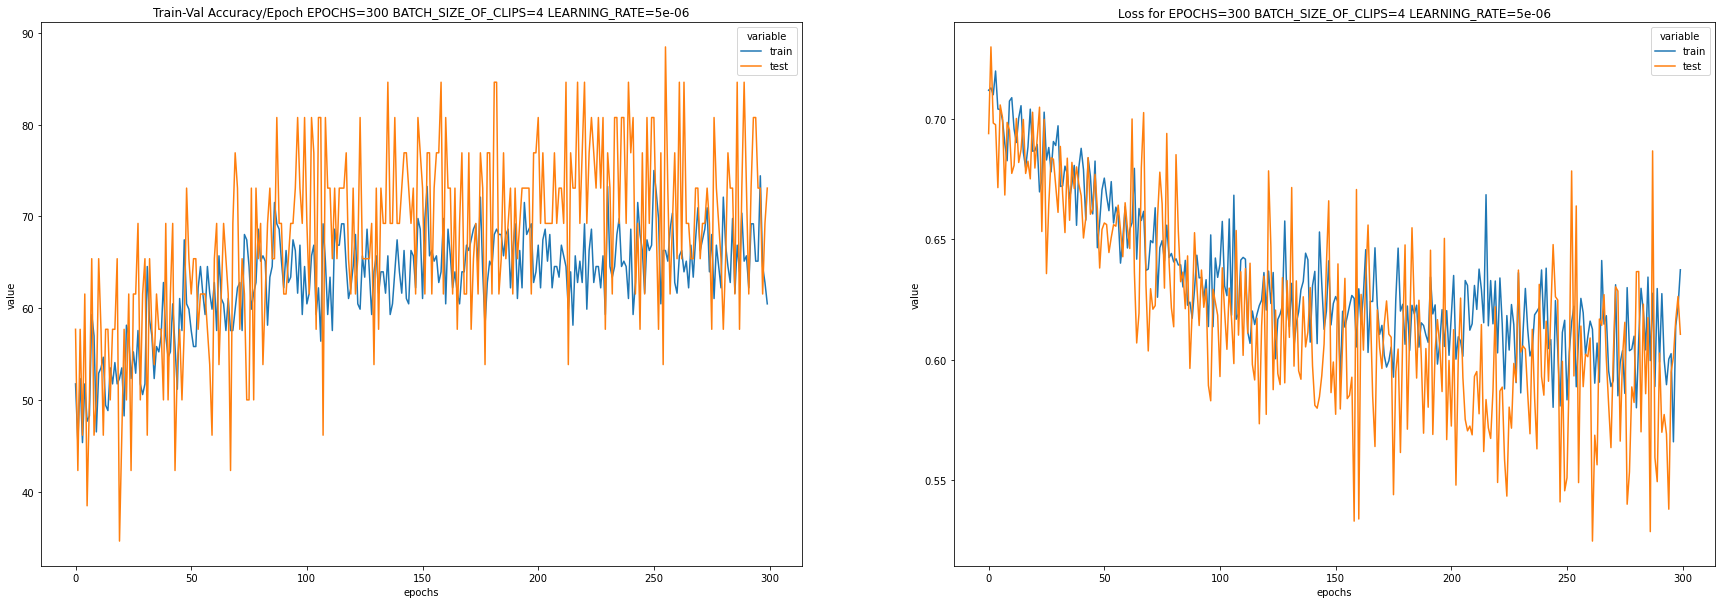

In [10]:


loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title(f'Loss for EPOCHS={MAX_EPOCHS} BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} LEARNING_RATE={LEARNING_RATE}')
sns.lineplot(data=acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title(f'Train-Val Accuracy/Epoch EPOCHS={MAX_EPOCHS} BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} LEARNING_RATE={LEARNING_RATE}')


                     


## 11. Evaluate the model on test dataset

In [11]:
model.load_state_dict(torch.load(
    os.path.join(model_path, "metric_model.pth")))
model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for clip_batch_idx, sample_batched in enumerate(test_dataloader):
        X_train_batch, y_train_batch = sample_batched[0].to(device), sample_batched[1].to(device)
        print(f'==================================================')
        print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        y_test_pred = model(X_train_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        for i in range(len(y_test_pred)):
            y_true_list.append(y_train_batch[i].cpu().item())
            y_pred_list.append(y_pred_tag[i].cpu().item())
            
        
print(f'==================================================')        
print(f'==================================================')        
print(get_class_distribution(test_set))
print(f'y_pred_list{y_pred_list}')
print(f'y_true_list{y_true_list}')





 BATCH_OF_CLIPS_INDEX: 0 
   X_train_batch.size(): torch.Size([4, 1, 60, 128, 128])
   y_train_batch.size(): torch.Size([4])
 BATCH_OF_CLIPS_INDEX: 1 
   X_train_batch.size(): torch.Size([4, 1, 60, 128, 128])
   y_train_batch.size(): torch.Size([4])
 BATCH_OF_CLIPS_INDEX: 2 
   X_train_batch.size(): torch.Size([4, 1, 60, 128, 128])
   y_train_batch.size(): torch.Size([4])


/tmp/ipykernel_57377/3550200339.py:99: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


 BATCH_OF_CLIPS_INDEX: 3 
   X_train_batch.size(): torch.Size([4, 1, 60, 128, 128])
   y_train_batch.size(): torch.Size([4])
 BATCH_OF_CLIPS_INDEX: 4 
   X_train_batch.size(): torch.Size([3, 1, 60, 128, 128])
   y_train_batch.size(): torch.Size([3])
{'BKGR': 12, '4CV': 7}
y_pred_list[0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
y_true_list[0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0]


              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.33      0.29      0.31         7

    accuracy                           0.53        19
   macro avg       0.47      0.48      0.47        19
weighted avg       0.51      0.53      0.52        19

[[8 4]
 [5 2]]


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

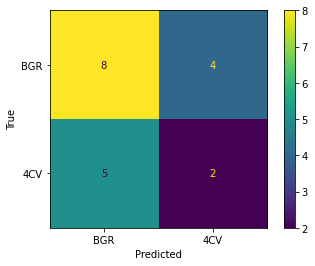

In [15]:
print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))

cm=confusion_matrix(y_true_list, y_pred_list)
#cm=confusion_matrix(y_true_list, y_pred_list, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['BGR','4CV'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

## 12. Cleanup data directory
Remove directory if a temporary was used.

In [13]:
#if model_path is None:
#   shutil.rmtree(model_path)
